In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time

from collections import namedtuple
from IPython.display import clear_output
from tqdm.notebook import tqdm
from numpy.typing import NDArray

from scipy.optimize import minimize
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile
from qiskit.circuit import Parameter, Instruction
from qiskit.circuit.library import RXGate, RYGate, RZGate, CXGate, CZGate, IGate
from qiskit_aer import AerSimulator

In [3]:
from qml.model.gate import get_gateset, GateInfo, Gate

In [4]:
class Unit:

    VALUE_MAX = 2 * np.pi

    def __init__(
            self,
            name: str,
            gates: list[Gate],
            params: list[Parameter],
            values: list[float] | NDArray,
    ):
        self._name = name
        self._gates = gates
        self._params = params
        self._values = np.asarray(values) % self.VALUE_MAX

    def feed_dict(self, values=None) -> dict[str, float]:
        if values is None:
            values = self.values
        if not hasattr(values, "__len__"):
            values = [values]
        assert len(values) == len(
            self.parameters), f"Length of values {len(values)} must be equal to number of parameters {len(self.values)}"

        feed_dict = dict()
        for param, value in zip(self._params, values):
            feed_dict |= {
                param.name: value
            }
        return feed_dict

    def apply_to_qc(self, qc: QuantumCircuit) -> QuantumCircuit:
        for gate in self._gates:
            gate.apply_to_qc(qc)
        return qc

    @staticmethod
    def generate_random_unit(
            name: str,
            num_qubit: int,
            num_gate: int,
            gateset: dict[str, GateInfo] = None,
    ):
        if gateset is None:
            gateset = get_gateset(num_qubit)

        # select gate at random
        gate_names_on_set = list(gateset.keys())
        gate_names = np.random.choice(gate_names_on_set, size=num_gate, replace=True)

        # select qubits to apply gates
        qubits = np.random.randint(0, num_qubit, size=num_gate)
        return Unit.new_with_gate_names_and_qubits(name, gate_names, qubits, gateset)

    @staticmethod
    def new_with_gate_names_and_qubits(
            name: str,
            gate_names: list[str],
            qubits: list[int],
            gateset: dict[str, GateInfo]
    ):
        gate_infos = [gateset[gate_name] for gate_name in gate_names]
        
        # build instance of gates and parameters
        gates = []
        params = []
        for gate_info, qubit in zip(gate_infos, qubits):
            if not gate_info.trainable:
                gates.append(Gate.new_with_info(gate_info, qubit))
                continue

            pname = f"param_{len(params)}"
            if name is not None:
                pname = name + "_" + pname
            param = Parameter(pname)
            params.append(param)
            gates.append(Gate.new_with_info(gate_info, qubit, param))

        # initialize parameter values
        values = np.zeros_like(params)

        return Unit(name, gates, params, values)

    @property
    def values(self):
        return self._values.copy()

    @values.setter
    def values(self, values):
        assert len(values) == len(
            self.values), f"Length of values {len(values)} must be equal to number of parameters {len(self.values)}"
        values = np.asarray(values)
        values = values % self.VALUE_MAX
        self._values = values

    @property
    def parameters(self):
        return self.values

    @parameters.setter
    def parameters(self, values):
        self.values = values

    @property
    def gates(self):
        return [gate for gate in self._gates]

    @property
    def parameter_instances(self):
        return self._params

    @property
    def num_param(self):
        return len(self._params)


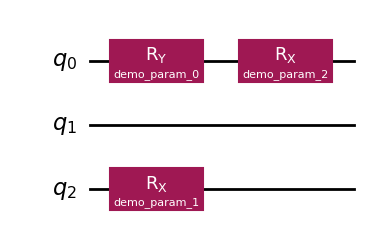

In [6]:
nq = 3
ng = 3
qc = QuantumCircuit(nq)

unit = Unit.generate_random_unit("demo", nq, ng)
unit.apply_to_qc(qc)

qc.draw("mpl")